In [1]:
import pandas

df = pandas.read_csv('./model_version_0.csv')
df

,lantus,humalog,glucose_diff,time_diff_minutes,mealcarbs_last_meal,humalog_last_meal
0,8.0,0.00,155,139,38.0,1.75
1,8.0,1.69,74,224,19.0,0.64
2,8.0,1.30,-60,297,21.0,1.16
3,8.0,0.00,149,134,31.0,1.02
4,8.0,2.10,75,278,34.0,1.66
5,8.0,0.00,-49,163,29.0,1.35
6,8.0,2.53,153,269,24.0,1.11
7,8.0,0.00,-198,201,33.0,2.64
8,8.0,0.00,-77,181,22.0,1.04
9,8.0,1.00,-131,279,9.0,1.50


In [2]:
from pymc3 import *
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline


glucose_diff = df['glucose_diff']
basal_given = df['lantus']
mealcarbs = df['mealcarbs_last_meal']
humalog = df['humalog_last_meal']
timediff_last_mealcarbs = df['time_diff_minutes']
timediff_last_glucose = df['time_diff_minutes']
timediff_last_humalog_last_glucose = df['time_diff_minutes']

import theano.tensor as T

# Assume that basal insulin is accurate dosage (this is a large assumption),
# We can try and incorporate this later with another variable.
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('intercept', 0, sd=10)

    # time_of_absorb_carbs = Bound(Normal, lower=0.0)('time_of_absorb_carbs', mu=40.0, sd=20)
    time_of_absorb_carbs = Uniform('time_of_absorb_carbs', lower=30, upper=120)
    
    time_of_absorb_humalog = Uniform('time_of_absorb_humalog', lower=180, upper=240)
    BoundedNormal = Bound(Normal, lower=0.0)

    CR = Uniform('CR',lower=0, upper=100)
    CF = Uniform('CF', lower=0, upper=250)

    percent_absorb_carbs = T.minimum(timediff_last_mealcarbs, time_of_absorb_carbs) / time_of_absorb_carbs

    #percent absorb humalog
    percent_left_absorb_humalog = T.maximum((time_of_absorb_humalog - timediff_last_humalog_last_glucose)/time_of_absorb_humalog, 0)
    percent_absorb_humalog = percent_left_absorb_humalog * timediff_last_glucose / (time_of_absorb_humalog - timediff_last_humalog_last_glucose)

    basal_actual = Normal('basal_actual', mu=6, sd=2)

    # Define likelihood
    likelihood = Normal('glucose_diff', mu=intercept + CF/CR * percent_absorb_carbs * mealcarbs \
                        - CF * percent_absorb_humalog * humalog \
                        + CF *.8* (basal_actual - basal_given) * 1/(24*60) * timediff_last_glucose
                        ,sd=sigma, observed=glucose_diff)
    
    # Inference!
    trace = sample(6000, tune=2000, progressbar=True) # draw posterior samples using NUTS sampling

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [basal_actual, CF_interval__, CR_interval__, time_of_absorb_humalog_interval__, time_of_absorb_carbs_interval__, intercept, sigma_log__]
100%|██████████| 8000/8000 [28:45<00:00,  4.64it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.697260191921, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


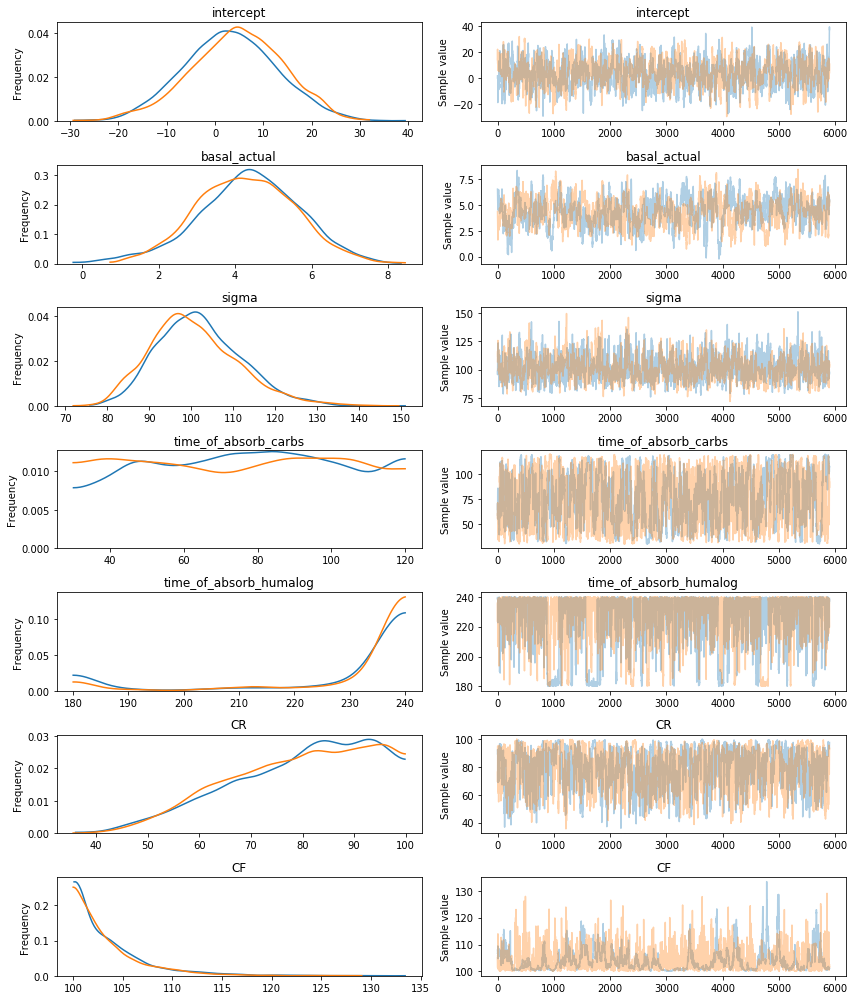

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

traceplot(trace[100:])
plt.tight_layout();